# Sentinel-2 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.
Both of the Sentinel-2 satellites carry an innovative wide swath high-resolution multispectral imager with 13 spectral bands.
For more information on the Sentinel-2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Overview4).

Digital Earth Africa (DE Africa) provides [Sentinel 2, Level 2A](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a-processing) surface reflectance data provided by ESA.
Surface reflectance provides standardised optical datasets by using robust physical models to correct for variations in image radiance values due to atmospheric properties, as well as sun and sensor geometry.
The resulting stack of surface reflectance grids are consistent over space and time, which is instrumental in identifying and quantifying environmental change.

DE Africa provides one Sentinel-2 surface reflectance product:

* **Sentinel-2** (i.e. `"s2a_l2a"`): This product represent the 'definitive' source of high quality, analysis-ready Sentinel-2 surface reflectance data (Level 2A), and is available from 2017 to present. Sentinel-2a and Sentinel-2b satellite sensors are stored together under a single product name.

Sentinel-2, Level 2A surface reflectance products have 13 spectral channels and one pixel quality band ([SCL](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)):

| Sentinel-2 bands | DE Africa band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `blue` | 2 | 490 | 10 | 65 |
| Green | `green` | 3 | 560 | 10 | 35 |
| Red | `red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nir_1`, `nir` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nir_2`,`nir_narrow` | 8A | 865 | 20 | 20 |
| Water vapour | `water_vapour` | 9 | 945 | 60 | 20 |
| SWIR | `swir_1`, `swir_16` | 11 | 1610 | 20 | 90 |
| SWIR | `swir_2`, `swir_22` | 12 | 2190 | 20 | 180 |
| SCL  | `SCL`, `qa`, `mask`    | 13 | N/A | 20
| AOT  | `aerosol_optical_thickness` | N/A | N/A | 60

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

!['Sentinel-2 spectral bands'](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

***

> **Product name in the datacube:** `"s2_l2a"`
`

**Important details:**
* Surface reflectance product (Level 2A)
    * Valid SR scaling range: `1 – 10,000 (0 is no-data)`
* Spatial resolution: varies, see above table
* [SCL](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) used as pixel quality band
* Universal Transverse Mercator (UTM) map projection. World Geodetic System (WGS) 84 datum
* Stored in Cloud-Optimised GeoTIFF Format (COG)

**Status:** 

DE Africa's Sentinel-2 data is processed to Level 2A using the [Sen2Cor](https://step.esa.int/main/third-party-plugins-2/sen2cor/) algorithm, stored as Cloud-Optimised Geotiffs, and is available over the entire African Continent. Sentinel-2a and Sentinel-2b satellite sensors are stored together under a single product name (`"s2_l2a"`). 

The catalogue is regularly updated to keep pace with new satellite passes.

**Date-range**: 

2017 to Present


**Minimum loading requirements:**

                data = dc.load(product="s2_l2a",
                               output_crs='epsg:6933',
                               resolution=(-20, 20),
                               **query)
                               
**Bands:**

        coastal_aerosol
        blue           
        green           
        red
        red_edge_1
        red_edge_2
        red_edge_3
        nir_1
        nir_2
        swir_1            
        swir_2
        water_vapour
        SCL        
        AOT
***

## Description

This notebook will run through loading in Sentinel-2 satellite images.
Topics covered include:

* Using the native `dc.load()` function to load in Sentinel-2 data
* Using the `load_ard()` wrapper function to load in a cloud and pixel-quality masked time series

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import datacube

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_2")

## Load Sentinel-2 data from the datacube

We will load **Sentinel-2** data using two methods.
Firstly, we will use [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images.
Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the `dc.load` module.
This function will load all the images from Sentinel-2 and then apply a cloud/pixel-quality mask.
The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/03_Loading_data.ipynb).

Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). 
The different satellite bands also have different resolutions (10 m, 20 m and 60 m). 
Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> **Note:** Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [3]:
# Create a query object
lat, lon = 22.821, 28.518
buffer = 0.05

query = {
    'time': ('2020-01', '2020-03'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:6933',
    'resolution':(-20,20),
}

### Load Sentinel-2 using `dc.load()`

The **Sentinel-2** product is called:

* `s2_l2a`

And contains images from both Sentinel-2 sensors, S2a and S2b

We will now load in a time-series of satellite images from only Sentinel-2

In [4]:
#load data
ds = dc.load(product="s2_l2a",
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 17, x: 483, y: 590)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T08:53:48 ... 2020-03-27T08:53:51
  * y            (y) float64 2.843e+06 2.843e+06 ... 2.831e+06 2.831e+06
  * x            (x) float64 2.747e+06 2.747e+06 ... 2.756e+06 2.756e+06
    spatial_ref  int32 0
Data variables:
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B06          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B07          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    B08          (time, y,

The returned dataset contains all of the bands available for Sentinel-2. These bands are named using the datasets native band-names.  We can also specify which bands to return using band-name `aliases`, such as `red` or `nir`. We do this using the parameter `measurements`.

In [5]:
bands = ["blue", "green", "red", 'nir', 'swir_1']

ds = dc.load(product="s2_l2a",
             measurements=bands,
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 17, x: 483, y: 590)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T08:53:48 ... 2020-03-27T08:53:51
  * y            (y) float64 2.843e+06 2.843e+06 ... 2.831e+06 2.831e+06
  * x            (x) float64 2.747e+06 2.747e+06 ... 2.756e+06 2.756e+06
    spatial_ref  int32 0
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    swir_1       (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


Once the load is complete, we can then analyse or plot the Sentinel-2 data. As you can see below, clouds and regions of no-data are visible.

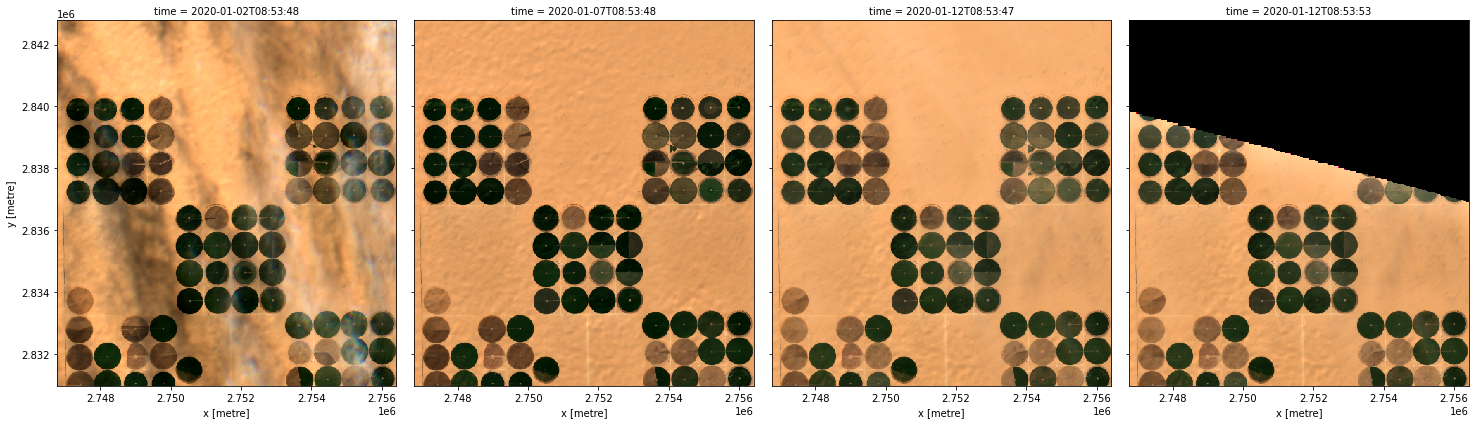

In [6]:
rgb(ds, index=[0,1,2,3])

### Load Sentinel-2 using `load_ard`

This function will load images from Sentinel-2 and apply a cloud/pixel-quality mask.
The result is an analysis ready dataset free of cloud, cloud-shadow, and missing data.

You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [8]:
ds = load_ard(dc=dc,
              products=["s2_l2a"],
              measurements=bands,
              dask_chunks={},
              **query)

print(ds)

In [ ]:
rgb(ds, index=[0,1,2,3])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()